In [1]:
import os
import numpy as np
import pandas as pd
import torch
import os
import json
import pandas as pd
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline
from tqdm import tqdm
import glob
import pickle

In [20]:
IMG_DIR = '/mnt/chicm/data/open-images/test'

In [3]:
# visualize

import numpy as np
import PIL.Image as Image
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont

INDIGO = (75, 0, 130)


def draw_bounding_box_on_image(
    image,
    x_min,
    y_min,
    x_max,
    y_max,
    color,
    thickness=4,
    display_str_list=(),
    use_normalized_coordinates=False,
    fontsize=20
):
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    if use_normalized_coordinates:
        (left, right, top, bottom) = (x_min * im_width, x_max * im_width, y_min * im_height, y_max * im_height)
    else:
        (left, right, top, bottom) = (x_min, x_max, y_min, y_max)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], width=thickness, fill=color)
    try:
        font = ImageFont.truetype('DejaVuSansMono.ttf', fontsize)
    except IOError:
        font = ImageFont.load_default()

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = bottom + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin), (left + text_width, text_bottom)], fill=color)
        draw.text((left + margin, text_bottom - text_height - margin), display_str, fill=color, font=font)
        text_bottom -= text_height - 2 * margin


def draw_bounding_boxes_on_image_array(
    image, bboxes, color=INDIGO, thickness=4, use_normalized_coordinates=False, fontsize=20
):
    image_pil = Image.fromarray(image)
    draw_bounding_boxes_on_image(image_pil, bboxes, color, thickness, use_normalized_coordinates, fontsize)
    np.copyto(image, np.array(image_pil))


def draw_bounding_boxes_on_image(
    image, bboxes, color=INDIGO, thickness=4, use_normalized_coordinates=False, fontsize=20
):
    for bbox in bboxes:
        draw_bounding_box_on_image(
            image, bbox[0], bbox[1], bbox[2], bbox[3], color, thickness, (), use_normalized_coordinates, fontsize
        )


In [7]:
!ls /mnt/chicm/open-images-vrd/vrd/lb25388/

cat_1000_0825_1416_cdiff.model
df_neg_small_2.csv
ensemble_detect_57_0820_1_top100.csv
sub_hits.csv
sub_tuple_0825_cdiff_at.csv
sub_tuple_0825_cdiff.csv
sub_tuple_0825_cdiff_exclude_inside_of.csv
sub_tuple_0825_cdiff_hits.csv
sub_tuple_0825_cdiff_inside_of.csv
sub_tuple_0825_cdiff_interacts_with.csv
sub_tuple_0825_cdiff_plays.csv
sub_tuple_0825_cdiff_under.csv
sub_tuple_0825_cdiff_wears.csv
sub_wears.csv


In [70]:
df = pd.read_csv('/mnt/chicm/open-images-vrd/vrd/lb25388/ensemble_detect_57_0820_1_top100.csv')
df.head()

,ImageId,PredictionString
0,21135d5ed0e7a0b7,/m/04yx4 0.8209846 0.3756532 0.2369880 0.75013...
1,763c72626bf24534,/m/04yx4 0.9761059 0.0059799 0.1897154 0.24897...
2,7540c162180973b1,/m/04yx4 0.6516410 0.7939431 0.1332737 0.85725...
3,c4e522dce52cb02f,/m/04yx4 0.9427195 0.3922202 0.2638703 0.54933...
4,cafcd9496c808085,/m/0k4j 0.0011794 0.7955955 0.0142576 0.999023...


In [71]:
#selected_classes = set(['/m/0342h', '/m/07y_7', '/m/026t6', '/m/05r5c', '/m/0l14j_'])
#selected_classes = set(['/m/04yx4', '/m/03bt1vf', '/m/01bl7v', '/m/05r655'])
selected_classes = set(['/m/01226z', '/m/0wdt60w', '/m/05ctyq'])

def get_dets(pred_str):
    if len(pred_str) < 1:
        return []
    dets = []
    det = []
    for i, e in enumerate(pred_str.split(' ')):
        if i % 6 == 0:
            det = []
        det.append(e)
        if (i+1) % 6 == 0 and det[0] in selected_classes and float(det[1]) > 0.1:
            dets.append(det)
    return dets            


In [72]:
df.PredictionString = df.PredictionString.fillna('')

In [73]:
df['dets'] = df.PredictionString.map(lambda x: get_dets(x))

In [74]:
df['num_dets'] = df.dets.map(lambda x: len(x))

In [75]:
df.loc[df.num_dets>0].sample(10)

,ImageId,PredictionString,dets,num_dets
77671,636bedd2090ad1c0,/m/04yx4 0.0067074 0.6473406 0.9549477 0.67846...,"[[/m/01226z, 0.3507236, 0.8072507, 0.2638713, ...",1
65881,9f4109fef3386587,/m/04yx4 0.0064145 0.5154164 0.8581558 0.64835...,"[[/m/05ctyq, 0.1310796, 0.0071016, 0.4753092, ...",1
58892,1fbccecfb8ef6017,/m/04yx4 0.0213493 0.0906693 0.0658450 0.79033...,"[[/m/01226z, 0.9944329, 0.2002050, 0.8178626, ...",1
43360,0c28e98d95988178,/m/04yx4 0.5664505 0.0141051 0.0163800 0.28667...,"[[/m/01226z, 0.1518783, 0.0287490, 0.1434580, ...",2
23351,243adedbfc091eed,/m/04yx4 0.0333169 0.3574365 0.1741278 0.60913...,"[[/m/01226z, 0.9939106, 0.2249540, 0.7538279, ...",1
5104,c1c7c5b3253fdee2,/m/04yx4 0.0132102 0.0926215 0.5445908 0.21253...,"[[/m/01226z, 0.9887268, 0.6599319, 0.8271919, ...",1
81268,ea93deb484e09f60,/m/04yx4 0.8910988 0.0044745 0.3166068 0.19271...,"[[/m/01226z, 0.1416095, 0.2627055, 0.8108180, ...",1
58811,f1e1e0fcef56b929,/m/04yx4 0.0102407 0.0083378 0.0009827 0.99033...,"[[/m/05ctyq, 0.8275907, 0.3601513, 0.3960769, ...",1
85163,332eb5534bc82035,/m/04yx4 0.0402252 0.4601933 0.1467627 0.75235...,"[[/m/01226z, 0.9868211, 0.2320422, 0.6639277, ...",1
46751,8a4c7df9ed9585c9,/m/04yx4 0.0061448 0.0066991 0.0159331 0.80048...,"[[/m/01226z, 0.2516633, 0.0040048, 0.0178316, ...",1


In [76]:
len(df.loc[df.num_dets>0])

1151

In [77]:
def show_dets(idx):
    row = df.iloc[idx]
    fn = os.path.join(IMG_DIR, row.ImageId+'.jpg')
    print(fn)
    img = Image.open(fn)
    bboxes = [x[2:] for x in row.dets]
    bboxes = np.array(bboxes).astype(np.float32)
    #print(bboxes)
    draw_bounding_boxes_on_image(img, bboxes, use_normalized_coordinates=True)
    plt.figure(figsize=(15, 10))
    
    plt.imshow(img)

/mnt/chicm/data/open-images/test/1fbccecfb8ef6017.jpg


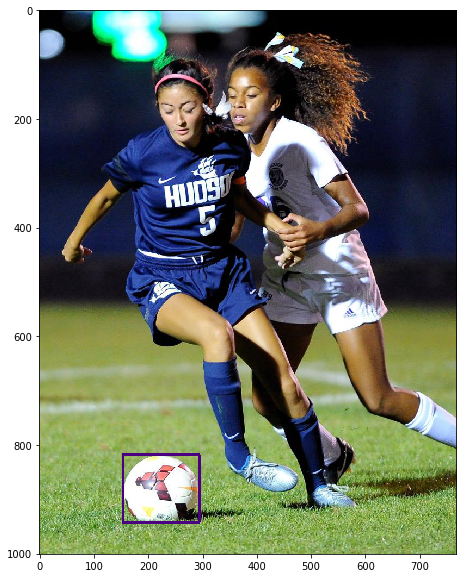

In [79]:
show_dets(58892)

In [ ]:
#  show neg samples

In [80]:
df_neg = pd.read_csv('/mnt/chicm/open-images-vrd/vrd/plays/df_neg.csv')
df_neg.head()

,ImageID,LabelName1,LabelName2,RelationshipLabel,XMax1,XMax2,XMin1,XMin2,YMax1,YMax2,YMin1,YMin2
0,0000201cd362f303,/m/03bt1vf,/m/026t6,none,0.395000,0.105000,0.250000,0.038125,0.729831,0.535647,0.236398,0.456848
1,0000201cd362f303,/m/03bt1vf,/m/026t6,none,0.395000,0.051250,0.250000,0.014375,0.729831,0.585366,0.236398,0.499062
2,0008abbbff45eb1e,/m/03bt1vf,/m/0342h,none,0.989729,0.689076,0.363212,0.046685,0.999375,0.586875,0.145625,0.098750
3,00459f8a9b8c62a2,/m/04yx4,/m/0342h,none,0.984991,0.776735,0.631645,0.607880,0.978618,0.995888,0.057566,0.687500
4,00459f8a9b8c62a2,/m/03bt1vf,/m/0342h,none,0.304565,0.776735,0.056285,0.607880,0.990954,0.995888,0.481086,0.687500


In [86]:
TRAIN_IMG_DIR = '/mnt/chicm/data/open-images/train/imgs'
img_files = glob.glob(TRAIN_IMG_DIR + '/**/*.jpg')
fullpath_dict = {}
for fn in img_files:
    fullpath_dict[os.path.basename(fn).split('.')[0]] = fn

In [89]:
def show_neg(idx):
    row = df_neg.iloc[idx]
    fn = fullpath_dict[row.ImageID]
    img = Image.open(fn)
    
    bboxes = [[row.XMin1, row.YMin1, row.XMax1, row.YMax1], [row.XMin2, row.YMin2, row.XMax2, row.YMax2]]
    #print(bboxes)
    draw_bounding_boxes_on_image(img, bboxes, use_normalized_coordinates=True)
    plt.figure(figsize=(15, 10))
    
    plt.imshow(img)
    

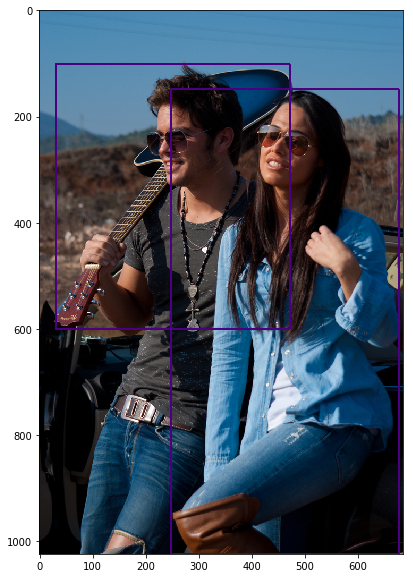

In [91]:
show_neg(2)